In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

sk


In [2]:
from langchain.document_loaders import TextLoader

# 메뉴판 텍스트 데이터를 로드
loader = TextLoader("../../data/cafe_menu_data.txt", encoding="utf-8")
documents = loader.load()

print(len(documents))

1


In [3]:
from langchain_core.documents import Document

# 문서 분할 (Chunking)
def split_menu_items(document):
    """
    메뉴 항목을 분리하는 함수 
    """
    # 정규표현식 정의 
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents


# 메뉴 항목 분리 실행
menu_documents = [] # [Document, Document]
for doc in documents:
    menu_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(menu_documents)}개의 메뉴 항목이 처리되었습니다.")
for doc in menu_documents[:2]:
    print(type(doc))
    pprint(vars(doc))
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

총 10개의 메뉴 항목이 처리되었습니다.
<class 'langchain_core.documents.base.Document'>
{'id': None,
 'metadata': {'menu_name': '아메리카노',
              'menu_number': 1,
              'source': '../../data/cafe_menu_data.txt'},
 'page_content': '1. 아메리카노\n'
                 '   • 가격: ₩4,500\n'
                 '   • 주요 원료: 에스프레소, 뜨거운 물\n'
                 '   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 '
                 '잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.',
 'type': 'Document'}

메뉴 번호: 1
메뉴 이름: 아메리카노
내용:
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 ...
<class 'langchain_core.documents.base.Document'>
{'id': None,
 'metadata': {'menu_name': '카페라떼',
              'menu_number': 2,
              'source': '../../data/cafe_menu_data.txt'},
 'page_content': '2. 카페라떼\n'
                 '   • 가격: ₩5,500\n'
                 '   • 주요 원료: 에스프레소, 스팀 밀크\n'
                 '   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings


embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# FAISS 인덱스 생성
cafe_db = FAISS.from_documents(
    documents=menu_documents, 
    embedding=embeddings_model
)

# FAISS 인덱스 저장 (선택사항)
cafe_db.save_local("../../db/cafe_db")


# Retriever 생성
menu_retriever = cafe_db.as_retriever(
    search_kwargs={'k': 4},
)


In [5]:
from typing import List
from langchain_core.tools import tool
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from pydantic import BaseModel, Field
from langchain_community.document_loaders import WikipediaLoader
from langchain_openai import ChatOpenAI
# Tool 정의 
# WikipediaLoader를 사용하여 위키피디아 문서를 검색하고 텍스트로 반환하는 함수 
def wiki_search_and_summarize(input_data: dict):
    wiki_loader = WikipediaLoader(query=input_data["query"], load_max_docs=2, lang="ko")
    wiki_docs = wiki_loader.load()

    formatted_docs =[
        f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
        for doc in wiki_docs
        ]
    
    return formatted_docs
# 요약 프롬프트 템플릿
summary_prompt = ChatPromptTemplate.from_template(
    "Summarize the following text in a concise manner:\n\n{context}\n\nSummary:"
)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
summary_chain = (
    {"context": RunnableLambda(wiki_search_and_summarize)}
    | summary_prompt | llm | StrOutputParser() 
)
# 도구 호출에 사용할 입력 스키마 정의 
class WikiSummarySchema(BaseModel):
    """Input schema for Wikipedia search."""
    query: str = Field(..., description="The query to search for in Wikipedia")

wiki_summary = summary_chain.as_tool(
    name="wiki_summary",
    description=dedent("""
        Use this tool when you need to search for information on Wikipedia.
        It searches for Wikipedia articles related to the user's query and returns
        a summarized text. This tool is useful when general knowledge
        or background information is required.
    """),
    args_schema=WikiSummarySchema
)

@tool
def tavily_search_func(query: str) -> str:
    """Searches the internet for information that does not exist in the database or for the latest information."""

    tavily_search = TavilySearchResults(max_results=2)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n---\n".join([
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in docs
        ])

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

@tool
def db_search_cafe_func(query: str) -> List[Document]:
    """
    Securely retrieve and access authorized cafe menu information from an encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = cafe_db.similarity_search(query, k=4)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]


tools = [tavily_search_func, wiki_summary, db_search_cafe_func]

C:\Users\user\AppData\Local\Temp\ipykernel_21336\3174128721.py:36: LangChainBetaWarning: This API is in beta and may change in the future.
  wiki_summary = summary_chain.as_tool(


In [9]:
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: db_search_cafe_func  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: db_search_cafe_func | 아메리카노 | ../../data/cafe_menu_data.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: tavily_search_func  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: tavily_search_func | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

<class 'langgraph.graph.state.CompiledStateGraph'>


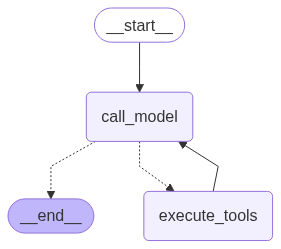

In [10]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
# ChatOpenAI 모델 초기화 
llm = ChatOpenAI(model="gpt-4o-mini")

# 4개의 검색 도구를 LLM에 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  db_search_cafe_func (call_H4j2DL8saNUiw719Okc2aWsI)
 Call ID: call_H4j2DL8saNUiw719Okc2aWsI
  Args:
    query: 아메리카노
================================= Tool Message =================================
Name: db_search_cafe_func

[Document(id='a4b01813-63ec-4273-8d44-f4a610555157', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 1, 'menu_name': '아메리카노'}, page_content='1. 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 뜨거운 물\n   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.'), Document(id='00d5480a-3278-4e2b-a492-44fe562a2eb4', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 9, 'menu_name': '아이스 아메리카노'}, page_content='9. 아이스 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 차가운 물, 얼음\n   • 설명: 진한 에스프레소에 차가운 물과 

In [12]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 기반 체크포인트 저장소 초기화
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

In [16]:
config = {
    "configurable": {"thread_id": "2"}  # 고유 세션 ID (사용자/채팅방 구분용)
}
messages = [HumanMessage(content="음료 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke(
    {"messages": messages},     # 입력 데이터
    config                      # 체크포인트 설정
)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  db_search_cafe_func (call_LBvn2EkVVJGIPLeC0ZwJapBQ)
 Call ID: call_LBvn2EkVVJGIPLeC0ZwJapBQ
  Args:
    query: 아메리카노
================================= Tool Message =================================
Name: db_search_cafe_func

[Document(id='a4b01813-63ec-4273-8d44-f4a610555157', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 1, 'menu_name': '아메리카노'}, page_content='1. 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 뜨거운 물\n   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.'), Document(id='00d5480a-3278-4e2b-a492-44fe562a2eb4', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 9, 'menu_name': '아이스 아메리카노'}, page_content='9. 아이스 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 차가운 물, 얼음\n   • 설명: 진한 에스프레소에 차가운 물과 

In [17]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="가장 싼 음료는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  db_search_cafe_func (call_LBvn2EkVVJGIPLeC0ZwJapBQ)
 Call ID: call_LBvn2EkVVJGIPLeC0ZwJapBQ
  Args:
    query: 아메리카노
================================= Tool Message =================================
Name: db_search_cafe_func

[Document(id='a4b01813-63ec-4273-8d44-f4a610555157', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 1, 'menu_name': '아메리카노'}, page_content='1. 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 뜨거운 물\n   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.'), Document(id='00d5480a-3278-4e2b-a492-44fe562a2eb4', metadata={'source': '../../data/cafe_menu_data.txt', 'menu_number': 9, 'menu_name': '아이스 아메리카노'}, page_content='9. 아이스 아메리카노\n   • 가격: ₩4,500\n   • 주요 원료: 에스프레소, 차가운 물, 얼음\n   • 설명: 진한 에스프레소에 차가운 물과 